In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import root_mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Importamos los datasets preparados 

X_train = pd.read_pickle("dataset/processed_data/linear/Xlm_train.pkl")
X_test = pd.read_pickle("dataset/processed_data/linear/Xlm_test.pkl")
y_train = pd.read_pickle("dataset/processed_data/linear/ylm_train.pkl")
y_test = pd.read_pickle("dataset/processed_data/linear/ylm_test.pkl")

In [4]:
elastic_net = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 1],  # Mixing values (0=Ridge, 1=Lasso)
    alphas=np.logspace(-4, 2, 50),  # Range of alpha values
    cv=5,  # 5-fold cross-validation
    max_iter=10000,
    random_state=42
)

elastic_net.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], max_iter=10000,
             random_state=42)

In [5]:
importancia_predictores = pd.Series(elastic_net.coef_, index=X_train.columns) 
print(importancia_predictores)

LotFrontage    -0.007306
LotArea         0.048062
OverallQual     0.087497
OverallCond     0.046125
YearBuilt       0.058017
                  ...   
GarageFinish    0.010339
GarageQual      0.012584
GarageCond      0.000000
Neighborhood    0.000000
ExterCond      -0.000000
Length: 133, dtype: float64


In [6]:
predictores_elegidos = importancia_predictores[abs(importancia_predictores) > 0.01].index
print(predictores_elegidos)


Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
       'GarageYrBlt', 'GarageCars', 'MSZoning_RM', 'LotShape_IR3',
       'LandContour_HLS', 'LotConfig_CulDSac', 'LandSlope_Mod',
       'Condition1_Norm', 'HouseStyle_SFoyer', 'Exterior1st_BrkFace',
       'MasVnrType_Stone', 'Foundation_PConc', 'Foundation_Slab',
       'MasVnrType_Stone', 'ExterQual', 'KitchenQual', 'Functional',
       'GarageFinish', 'GarageQual'],
      dtype='object')


In [7]:
print(len(predictores_elegidos))

29


In [8]:
joblib.dump(predictores_elegidos, "modelos/elastic_net/predictores_elastic_net.pkl")

['modelos/elastic_net/predictores_elastic_net.pkl']

In [9]:
predicciones_en = elastic_net.predict(X_test)


In [10]:
rmse = root_mean_squared_error(y_test, predicciones_en)
r2 = r2_score(y_test, predicciones_en)

In [11]:
print(f"✅ Desempeno Elastic Net:")
print(f"Test RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

✅ Desempeno Elastic Net:
Test RMSE: 0.15
R² Score: 0.881


In [12]:
predicciones_real = np.expm1(predicciones_en)  
y_test_real = np.expm1(y_test)

In [13]:
rmse_real = root_mean_squared_error(y_test_real, predicciones_real)
print(rmse_real)

31944.77616273693


In [14]:
margen_error = (rmse_real / y_test_real.mean()) * 100

In [15]:
print(margen_error)

17.862228700148613


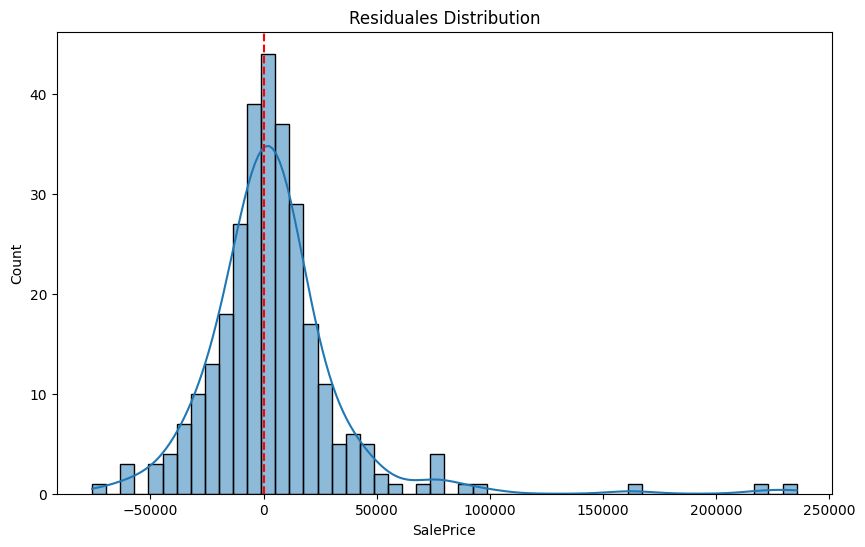

In [15]:
# Analisis del rendimiento 

residuales = y_test_real - predicciones_real

plt.figure(figsize=(10,6))
sns.histplot(residuales, bins=50, kde=True)
plt.axvline(x=0, color='red', linestyle='dashed')
plt.title("Residuales Distribution")
plt.show()

In [16]:
df_resultados1 = pd.DataFrame({"Real": y_test_real, "Predicciones": predicciones_real, "Residuales": residuales})
df_resultados1.sort_values(by="Residuales", ascending=False).head(10)


,Real,Predicciones,Residuales
691,755000.0,519496.380446,235503.619554
898,611657.0,390152.702324,221504.297676
1046,556581.0,394352.000346,162228.999654
774,395000.0,296704.044553,98295.955447
1243,465000.0,374894.015915,90105.984085
231,403000.0,324040.096095,78959.903905
591,451950.0,375627.686508,76322.313492
218,311500.0,235318.852232,76181.147768
585,369900.0,294168.180456,75731.819544
718,341000.0,268735.358112,72264.641888


In [17]:
importancia_predictores = pd.Series(elastic_net.coef_, index=X_train.columns).sort_values(ascending=False)
print(importancia_predictores.head(30))


GrLivArea              0.132787
OverallQual            0.087497
Exterior1st_BrkFace    0.064746
YearBuilt              0.058017
Condition1_Norm        0.050211
LotArea                0.048062
OverallCond            0.046125
LandContour_HLS        0.041815
1stFlrSF               0.041712
Functional             0.041386
GarageCars             0.037548
KitchenQual            0.032995
Foundation_PConc       0.029831
LandSlope_Mod          0.022574
ExterQual              0.020240
YearRemodAdd           0.018759
LotConfig_CulDSac      0.016208
HalfBath               0.014367
HouseStyle_SFoyer      0.013388
GarageQual             0.012584
MasVnrType_Stone       0.011917
MasVnrType_Stone       0.011910
GarageFinish           0.010339
Exterior1st_MetalSd    0.009558
GarageArea             0.006773
MSZoning_FV            0.006349
GarageType_Attchd      0.003443
GarageType_Attchd      0.003433
Exterior1st_CemntBd    0.003403
LandContour_Low        0.000716
dtype: float64


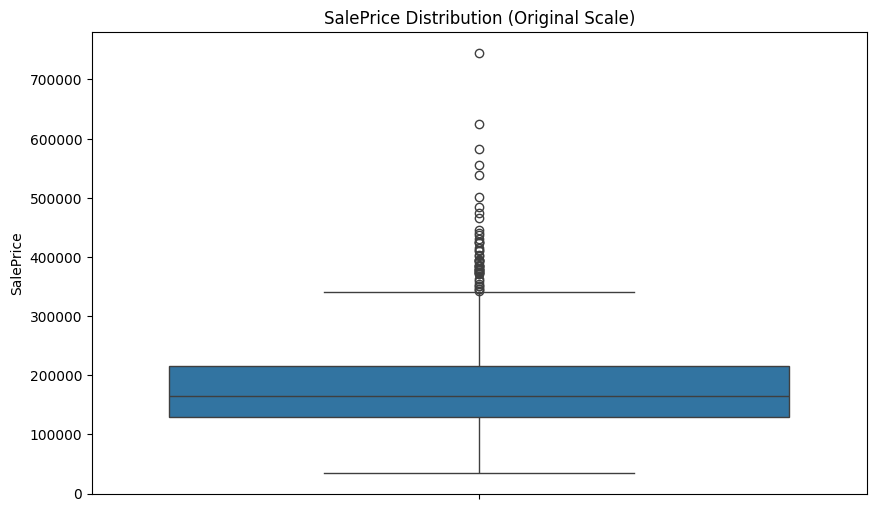

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(y=np.expm1(y_train))  # Reverse log transformation
plt.title("SalePrice Distribution (Original Scale)")
plt.show()

In [19]:
df_train_results = pd.DataFrame({"SalePrice": np.expm1(y_train)})
df_train_results["Z-Score"] = (df_train_results["SalePrice"] - df_train_results["SalePrice"].mean()) / df_train_results["SalePrice"].std()
df_train_results.sort_values(by="SalePrice", ascending=False).head(20)  # Check highest prices


,SalePrice,Z-Score
1182,745000.0,7.293973
1169,625000.0,5.740848
803,582933.0,5.196387
440,555000.0,4.834858
769,538000.0,4.614832
178,501837.0,4.146785
798,485000.0,3.928868
185,475000.0,3.799441
1373,466500.0,3.689428
527,446261.0,3.427481


In [1]:
upper_limit = np.expm1(y_train).quantile(0.99)  # Top 1%

# Filter out extreme expensive homes
y_train_filtered = y_train[np.expm1(y_train) < upper_limit]
X_train_filtered = X_train.loc[y_train_filtered.index] 

NameError: name 'np' is not defined

In [21]:
elastic_net2 = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 1],  # Mixing values (0=Ridge, 1=Lasso)
    alphas=np.logspace(-4, 2, 50),  # Range of alpha values
    cv=5,  # 5-fold cross-validation
    max_iter=10000,
    random_state=42
)

elastic_net2.fit(X_train_filtered, y_train_filtered)

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], max_iter=10000,
             random_state=42)

In [22]:
predicciones2 = elastic_net2.predict(X_test)

In [23]:
predicciones2_reales = np.expm1(predicciones2)
rmse2_real = root_mean_squared_error(y_test_real, predicciones2_reales)
print(rmse2_real)

33683.24809204173


In [24]:
margen_error2 = (rmse2_real / y_test_real.mean()) * 100
print(margen_error2)

18.834311992635534


In [25]:
# Assuming top_features is defined as before
top_features = importancia_predictores[abs(importancia_predictores) > 0.015].index

# Create dictionaries to hold interaction terms
interaction_features_train = {}
interaction_features_test = {}

# Create interaction terms without fragmenting the DataFrame
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        feat_name = f"{top_features[i]}_{top_features[j]}_inter"
        interaction_features_train[feat_name] = X_train_filtered[top_features[i]] * X_train_filtered[top_features[j]]
        interaction_features_test[feat_name] = X_test[top_features[i]] * X_test[top_features[j]]

# Convert dictionaries to DataFrames
interaction_df_train = pd.DataFrame(interaction_features_train, index=X_train_filtered.index)
interaction_df_test = pd.DataFrame(interaction_features_test, index=X_test.index)

# Concatenate all new features at once
X_train_enhanced = pd.concat([X_train_filtered, interaction_df_train], axis=1)
X_test_enhanced = pd.concat([X_test, interaction_df_test], axis=1)

# Continue with model training as before
elastic_net_enhanced = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1],
    alphas=np.logspace(-5, 3, 100),
    cv=10,
    max_iter=25000,
    tol=1e-5,
    random_state=42
)

elastic_net_enhanced.fit(X_train_enhanced, y_train_filtered)
predicciones_enhanced = elastic_net_enhanced.predict(X_test_enhanced)
predicciones_enhanced_real = np.expm1(predicciones_enhanced)
rmse_enhanced = root_mean_squared_error(y_test_real, predicciones_enhanced_real)
margen_error_enhanced = (rmse_enhanced / y_test_real.mean()) * 100

print(f"Original Error Margin: {margen_error2:.2f}%")
print(f"Enhanced Error Margin: {margen_error_enhanced:.2f}%")


KeyboardInterrupt: 

In [ ]:
# 1. Feature Engineering with Polynomial Features and Careful Selection
from sklearn.preprocessing import PolynomialFeatures

# Select top features with higher threshold
top_features = importancia_predictores[abs(importancia_predictores) > 0.02].index
X_train_enhanced = X_train_filtered[top_features].copy()
X_test_enhanced = X_test[top_features].copy()

# Add polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_enhanced)
X_test_poly = poly.transform(X_test_enhanced)

# Create DataFrame with feature names
feature_names = [f"feat_{i}" for i in range(X_train_poly.shape[1])]
X_train_enhanced = pd.DataFrame(X_train_poly, columns=feature_names)
X_test_enhanced = pd.DataFrame(X_test_poly, columns=feature_names)

# 2. Enhanced Model with Robust Hyperparameters
elastic_net_enhanced = ElasticNetCV(
	l1_ratio=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99],  # More granular mixing values
	alphas=np.logspace(-6, 3, 100),  # Broader range of alphas
	cv=10,
	max_iter=40000,
	tol=1e-6,
	random_state=42,
	selection='random'  # Try random feature selection
)

# Fit the enhanced model
elastic_net_enhanced.fit(X_train_enhanced, y_train_filtered)

# Make predictions and evaluate
predicciones_enhanced = elastic_net_enhanced.predict(X_test_enhanced)
predicciones_enhanced_real = np.expm1(predicciones_enhanced)
rmse_enhanced = root_mean_squared_error(y_test_real, predicciones_enhanced_real)
margen_error_enhanced = (rmse_enhanced / y_test_real.mean()) * 100

print(f"Original Error Margin: {margen_error2:.2f}%")
print(f"Enhanced Error Margin: {margen_error_enhanced:.2f}%")

# Print best parameters
print("\nBest Parameters:")
print(f"Best alpha: {elastic_net_enhanced.alpha_:.6f}")
print(f"Best l1_ratio: {elastic_net_enhanced.l1_ratio_:.3f}")


In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Select important features
top_features = importancia_predictores[abs(importancia_predictores) > 0.02].index
X_train_selected = X_train_filtered[top_features].copy()
X_test_selected = X_test[top_features].copy()

# 2. Scale the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
	scaler.fit_transform(X_train_selected),
	columns=X_train_selected.columns,
	index=X_train_selected.index
)
X_test_scaled = pd.DataFrame(
	scaler.transform(X_test_selected),
	columns=X_test_selected.columns,
	index=X_test_selected.index
)

# 3. Create simple interaction terms for top 10 features
top_10_features = importancia_predictores[abs(importancia_predictores) > 0.05].index[:10]
for i in range(len(top_10_features)):
	for j in range(i+1, len(top_10_features)):
		feat_name = f"{top_10_features[i]}_{top_10_features[j]}"
		X_train_scaled[feat_name] = X_train_scaled[top_10_features[i]] * X_train_scaled[top_10_features[j]]
		X_test_scaled[feat_name] = X_test_scaled[top_10_features[i]] * X_test_scaled[top_10_features[j]]

# 4. Train more stable ElasticNet
elastic_net_stable = ElasticNetCV(
	l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
	alphas=np.logspace(-3, 1, 30),
	cv=5,
	max_iter=5000,
	tol=1e-4,
	random_state=42
)

# Fit the model
elastic_net_stable.fit(X_train_scaled, y_train_filtered)

# Make predictions
predicciones_stable = elastic_net_stable.predict(X_test_scaled)
predicciones_stable_real = np.expm1(predicciones_stable)
rmse_stable = root_mean_squared_error(y_test_real, predicciones_stable_real)
margen_error_stable = (rmse_stable / y_test_real.mean()) * 100

print(f"Original Error Margin: {margen_error2:.2f}%")
print(f"Stable Enhanced Error Margin: {margen_error_stable:.2f}%")

# Print model info
print("\nModel Information:")
print(f"Convergence achieved: {elastic_net_stable.n_iter_}")
print(f"Best alpha: {elastic_net_stable.alpha_:.6f}")
print(f"Best l1_ratio: {elastic_net_stable.l1_ratio_:.3f}")


In [28]:
# 1. More selective feature selection and advanced feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

top_features = importancia_predictores[abs(importancia_predictores) > 0.01].index
X_train_selected = X_train_filtered[top_features].copy()
X_test_selected = X_test[top_features].copy()

# 2. Apply log transformation to highly skewed numeric features
for col in X_train_selected.select_dtypes(include=['float64', 'int64']).columns:
    skew = X_train_selected[col].skew()
    if abs(skew) > 0.75:
        X_train_selected[col] = np.log1p(X_train_selected[col])
        X_test_selected[col] = np.log1p(X_test_selected[col])

# 3. Standard scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_selected),
    columns=X_train_selected.columns,
    index=X_train_selected.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_selected),
    columns=X_test_selected.columns,
    index=X_test_selected.index
)

# 4. Add polynomial features (degree 2) for top features only
top_5_features = importancia_predictores[abs(importancia_predictores) > 0.1].index[:5]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_train_scaled[top_5_features])
poly_feature_names = [f'poly_{i}' for i in range(poly_features.shape[1])]
X_train_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=X_train_scaled.index)
X_test_poly = pd.DataFrame(
    poly.transform(X_test_scaled[top_5_features]), 
    columns=poly_feature_names,
    index=X_test_scaled.index
)

# 5. Combine all features
X_train_final = pd.concat([X_train_scaled, X_train_poly], axis=1)
X_test_final = pd.concat([X_test_scaled, X_test_poly], axis=1)

# 6. Train elastic net with more robust parameters
elastic_net_final = ElasticNetCV(
    l1_ratio=[0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99],
    alphas=np.logspace(-5, 2, 100),
    cv=10,
    max_iter=50000,
    tol=1e-7,
    random_state=42,
    selection='random'
)

# 7. Fit and evaluate
elastic_net_final.fit(X_train_final, y_train_filtered)
predicciones_final = elastic_net_final.predict(X_test_final)
predicciones_final_real = np.expm1(predicciones_final)
rmse_final = root_mean_squared_error(y_test_real, predicciones_final_real)
margen_error_final = (rmse_final / y_test_real.mean()) * 100

print(f"Previous Error Margin: {margen_error2:.2f}%")
print(f"New Error Margin: {margen_error_final:.2f}%")
print("\nModel Parameters:")
print(f"Best alpha: {elastic_net_final.alpha_:.6f}")
print(f"Best l1_ratio: {elastic_net_final.l1_ratio_:.3f}")

/home/fbs/Desktop/Trabajo/prediccion-precios/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input X contains NaN.
ElasticNetCV does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values